In [1]:
import json
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plt.style.use('Solarize_Light2')

## Tournaments

In [2]:
df = pd.read_json('tournament_data.json')
df.columns = ["code", "date", "desc", "city", "country", "class", "rounds", "players", "submitter"]
df = df.iloc[::-1]

### Categorize tournament types and sanity check

In [3]:
def categorize(t):
    if 'memorial' in t.lower():
        return 'memorial'
    if 'marathon' in t.lower() or 'marthon' in t.lower() or t == 'Summer Go Camp':
        return 'marathon'
    if 'entrance' in t.lower() or 'entry' in t.lower() or t == 'Summer Go School' or t == 'Summer Go School Rapid':
        return 'entrance'
    return 'other'

df['year'] = pd.to_datetime(df['date']).dt.year
df['type'] = df['desc'].apply(categorize)
df_grouped = df.groupby(['year', 'type']).size().unstack(fill_value=0)
df_grouped = df_grouped.reindex(columns=['entrance', 'memorial', 'marathon'], fill_value=0)
df_grouped

type,entrance,memorial,marathon
year,,,
2005,1,1,0
2006,1,1,1
2007,1,1,1
2008,1,1,1
2009,1,1,2
2010,1,1,1
2011,1,1,1
2012,1,1,1
2013,1,1,2


### Overview of tournaments played

In [4]:
df_filtered = df[df['type'] != 'other'].copy()
df_filtered['type'] = df_filtered.groupby(['year', 'type']).cumcount().add(1).astype(str).where(df_filtered['type'] == 'marathon', '').radd(df_filtered['type'])

pivot_df = df_filtered.pivot_table(index='year', columns='type', values=['players', 'rounds', 'class'], aggfunc='first')

# Reorder the columns
column_order = ['entrance', 'marathon1', 'memorial', 'marathon2']
pivot_df = pivot_df.reorder_levels([1, 0], axis=1).sort_index(axis=1)
pivot_df = pivot_df.reindex(columns=column_order, level=0, fill_value=0)

pivot_df

type entrance                marathon1                memorial                 \
        class players rounds     class players rounds    class players rounds   
year                                                                            
2005        C    63.0    4.0       NaN     NaN    NaN        B    60.0    6.0   
2006        C    73.0    4.0         B    52.0    6.0        A    86.0    6.0   
2007        C    55.0    4.0         A    69.0    7.0        A    62.0    6.0   
2008        C    62.0    4.0         A    72.0    9.0        A    61.0    6.0   
2009        B    43.0    4.0         A    56.0    6.0        A    57.0    6.0   
2010        C    42.0    6.0         A    43.0    5.0        A    37.0    6.0   
2011        B    60.0    4.0         A    73.0   10.0        A    56.0    6.0   
2012        B    51.0    4.0         A    66.0   10.0        A    54.0    6.0   
2013        C    38.0    4.0         A    48.0    5.0        A    31.0    5.0   
2014        B    27.0    4.0         A    27.0    5.0        A    29.0    6.0   
2015        B    26.0    4.0         A    28.0    8.0        A    20.0    6.0   
2016        B    37.0    4.0         A    29.0    8.0        A    33.0    6.0   
2017        B    35.0    4.0         A    36.0    8.0        A    34.0    6.0   
2018        B    28.0    4.0         A    25.0    4.0        A    28.0    6.0   
2019        B    37.0    4.0         A    35.0    4.0        A    26.0    6.0   
2020        B    36.0    4.0         A    32.0    7.0        A    30.0    5.0   
2021        B    37.0    4.0         A    44.0    5.0        A    34.0    6.0   
2022        B    36.0    4.0         A    37.0    5.0        A    43.0    6.0   
2023        B    36.0    4.0         A    41.0    5.0        A    46.0    6.0   
2024        B    36.0    4.0         A    42.0    5.0        A    39.0    6.0   

type marathon2                 
         class players rounds  
year                           
2005       NaN     NaN    NaN  
2006       NaN     NaN    NaN  
2007       NaN     NaN    NaN  
2008       NaN     NaN    NaN  
2009         A    66.0    5.0  
2010       NaN     NaN    NaN  
2011       NaN     NaN    NaN  
2012       NaN     NaN    NaN  
2013         A    39.0    5.0  
2014         A    30.0    5.0  
2015       NaN     NaN    NaN  
2016       NaN     NaN    NaN  
2017       NaN     NaN    NaN  
2018         A    26.0    4.0  
2019         A    40.0    4.0  
2020       NaN     NaN    NaN  
2021         A    33.0    5.0  
2022         A    33.0    5.0  
2023         A    24.0    5.0  
2024         A    30.0    5.0

### Visualization

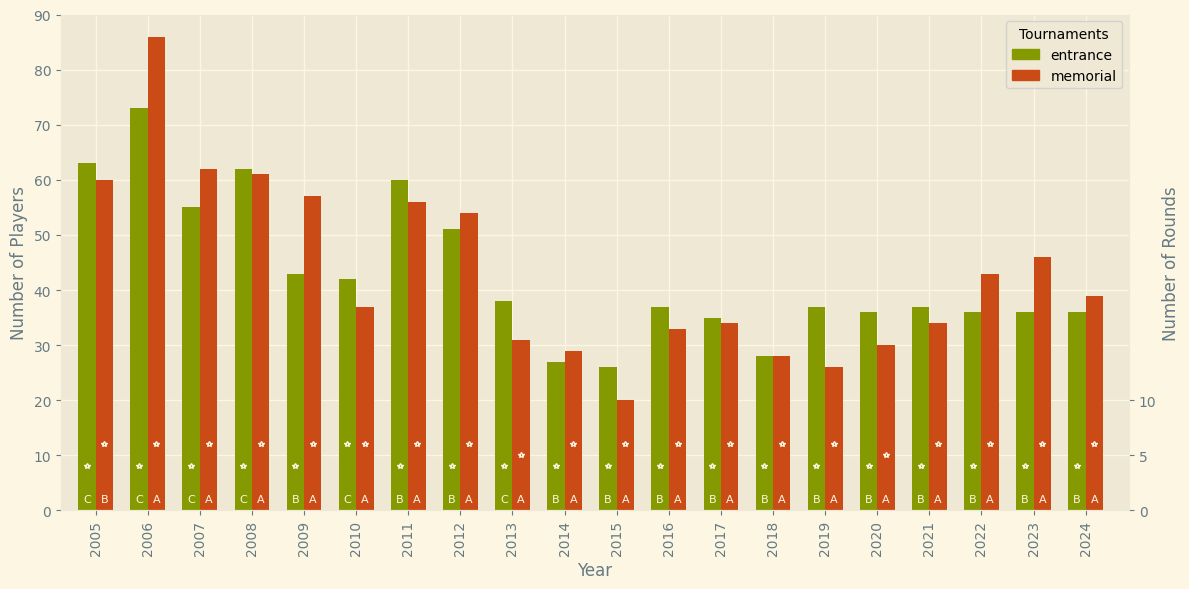

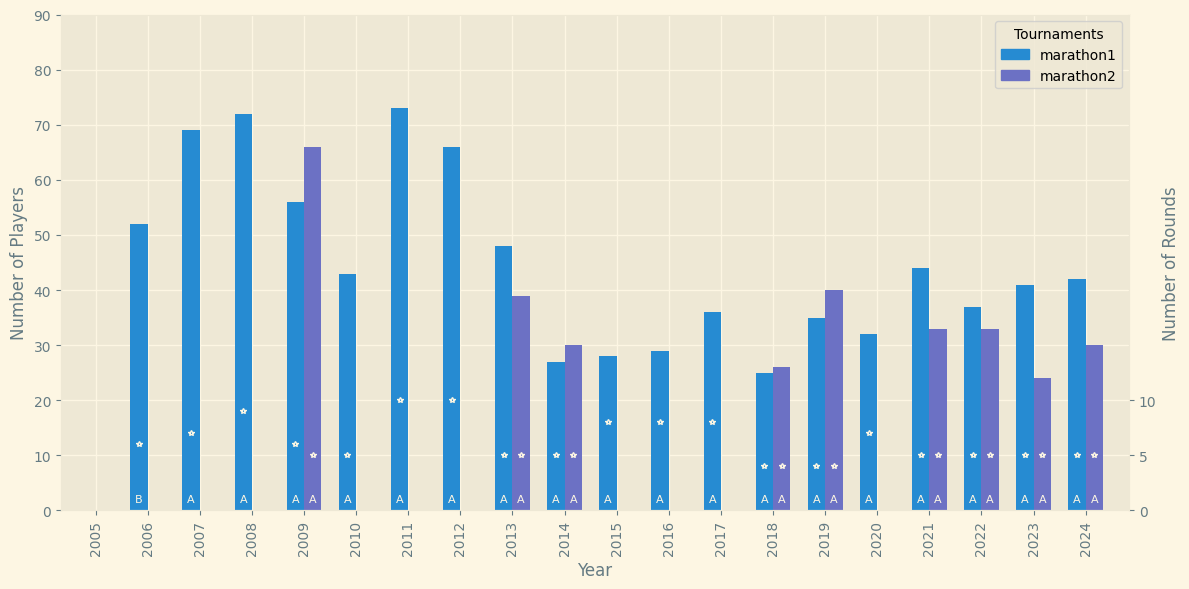

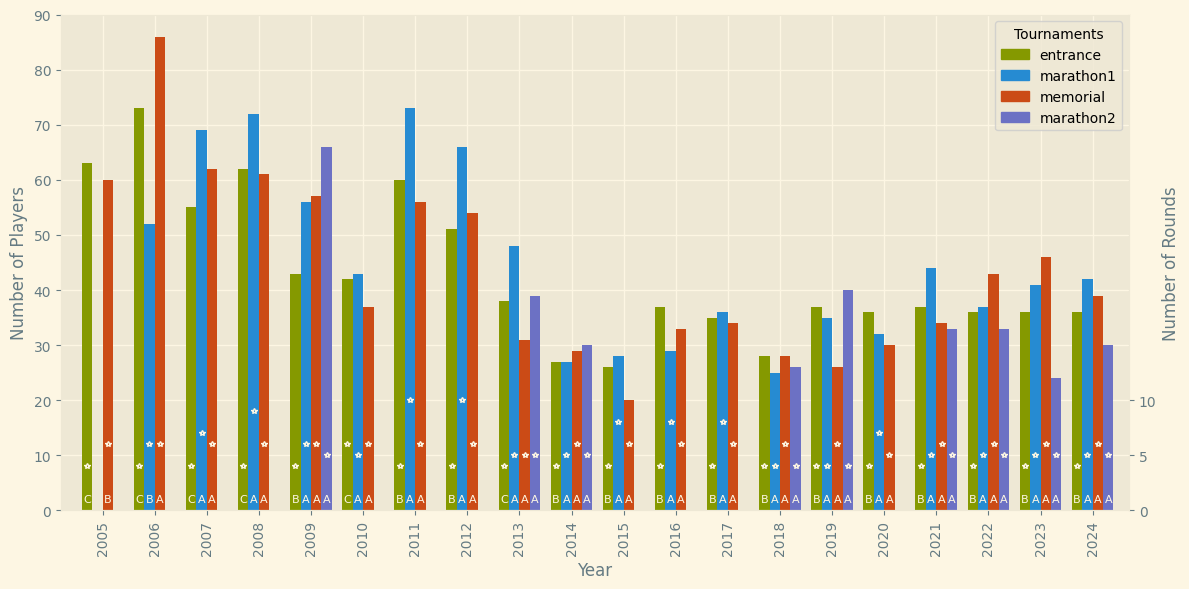

In [5]:
def plot_tournaments(colors, tournaments):
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax2 = ax1.twinx()

    width = 1 / (len(tournaments) + 1)
    for i, year in enumerate(pivot_df.index):
        for j, tour in enumerate(tournaments):
            t = pivot_df[tour].iloc[i]
            if not pd.isna(t['players']):
                ax1.bar(i + j * width, t['players'], width=width, color=colors[j])
                ax2.plot(i + j * width, t['rounds'], '*', markerfacecolor=colors[j], markeredgecolor='#fdf6e3', markersize=4)
                ax2.text(i + j * width, 1, t['class'], ha='center', va='center', fontsize=8, color='#fdf6e3')

    ax1.set_xlim(-0.5, len(pivot_df.index))
    ax1.set_xticks([i + width*(len(tournaments)/2 - 0.5) for i in range(len(pivot_df.index))])
    ax1.set_xticklabels(pivot_df.index, rotation=90)

    ax1.set_xlabel('Year')
    ax1.set_ylabel('Number of Players')
    ax1.set_ylim(0, 90)
    ax1.set_yticks(range(0, 100, 10))

    ax2.set_ylabel('Number of Rounds')
    ax2.set_ylim(0, 45)
    ax2.set_yticks([0, 5, 10])
    ax2.grid(False)

    handles = [patches.Patch(color=color, label=label) for color, label in zip(colors, tournaments)]
    ax1.legend(handles=handles, title='Tournaments')

    plt.tight_layout()
    plt.show()

plot_tournaments(['#859900', '#cb4b16'], ['entrance', 'memorial'])
plot_tournaments(['#268bd2', '#6c71c4'], ['marathon1', 'marathon2'])
plot_tournaments(['#859900', '#268bd2', '#cb4b16', '#6c71c4'], ['entrance', 'marathon1', 'memorial', 'marathon2'])

## Registrations

In [6]:
with open('zarejestrowani.json', 'r') as f:
    zarejestrowani = json.load(f)

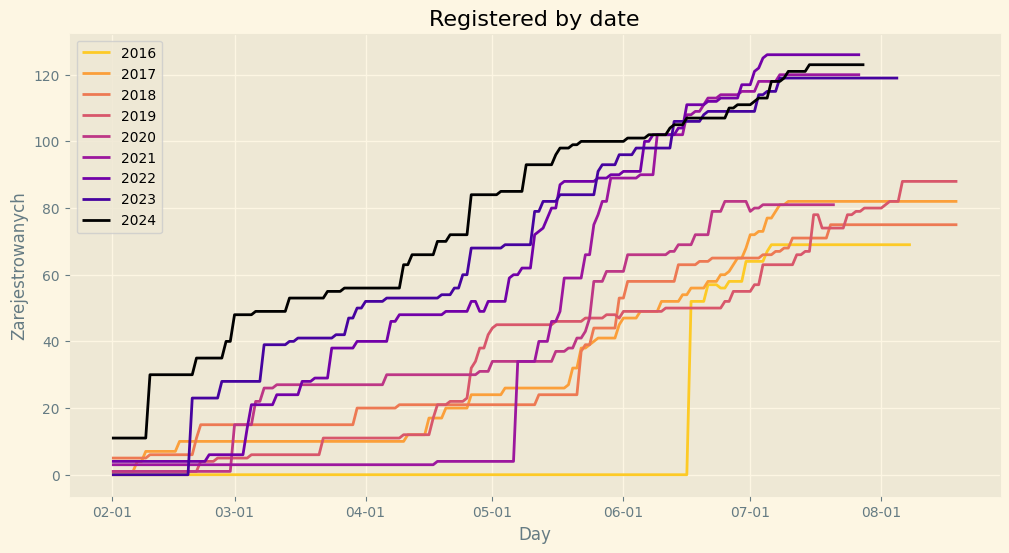

In [7]:
num_years = len(zarejestrowani)
colors = [cm.plasma((x+1) / num_years) for x in reversed(range(num_years-1))]
colors.append((0, 0, 0, 1))

plt.figure(figsize=(12, 6))

for (year, values), color in zip(zarejestrowani.items(), colors):
    dates = list(values.keys())
    counts = list(values.values())
    plt.plot(dates, counts, label=year, color=color)

ticks = []
for month in range(2, 9):
    ticks.append(f"0{month}-01")
plt.xticks(ticks, [date for date in ticks])

plt.xlabel('Day')
plt.ylabel('Zarejestrowanych')
plt.title("Registered by date")
plt.legend()
plt.show()